In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary, positive
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

set_default_float(np.float64)
set_default_summary_fmt("notebook")

plt.style.use("ggplot")
%matplotlib inline
np.random.seed(10)

Choose input data

In [2]:

# define database '297' or '388'
N = 388

# define numbe rof training dataset
n_train = 20


In [3]:

if N == 297:
    data_E = './data/297_energy.txt'
    data_pd = './data/297_octonion_pd.txt'
    data_axes = './data/sigma3_data.txt'
    if n_train > N:
        print('The numbe rof trainign datset should be smaller than 297')
else:
    data_E = './data/energy_olms.txt'
    data_pd = './data/pd_olms.txt'
    if n_train > N:
        print('The numbe rof trainign datset should be smaller than 388')


In [4]:
def ax2spher(ax):
    # all the vectors are normalized so r=1
    # theta is between 0, 2pi
    theta = np.arctan(ax[1]/ax[0])*180/np.pi # angle with z axis
    # phi is between 0 and pi
    phi = np.arccos(ax[2])*180/np.pi # angle with x axis
    return theta, phi

if N == '297':  
    data = np.loadtxt(data_axes)
    axes = data[:,0:3]

    n_axes = axes/np.linalg.norm(axes, axis=1, keepdims=True)
    n_data = len(n_axes)
    angles = np.zeros((n_data,2))
    for i in range(n_data):
        theta, phi = ax2spher(n_axes[i,:])
        angles[i] = np.array([theta, phi])
    print('Theta is in the range of:')
    range_theta = [np.min(angles[:,0]), np.max(angles[:,0])]
    print(range_theta)

    print('\nphi is in the range of:')
    range_phi = [np.min(angles[:,1]), np.max(angles[:,1])]
    print(range_phi)

In [5]:
class GBKernel(gpflow.kernels.Matern12):
    """
    Isotropic RBF Kernel with Haversine distance instead of euclidean distance.
    Assumes 2 dimensional data, with columns [latitude, longitude] in degrees.
    """

    def __init__(self, lengthscales=1.0):
        super().__init__(active_dims=[0])

    def _octonion_dist(self, X, X2):
        pd = np.loadtxt(data_pd)
        xx = np.unique(np.concatenate((id_test, id_train), axis= 0)).reshape(-1,1)

        len_x = len(xx)
        dist = np.zeros((len_x, len_x))
        for i in range(len_x):
            for j in range(len_x):
                dist[i,j] = pd[int(xx[i]), int(xx[j])]
        return dist

#     @params_as_tensors
    def _scaled_square_dist(self, X, X2):
        """
    The Matern 1/2 kernel. Functions drawn from a GP with this kernel are not
    differentiable anywhere. The kernel equation is

    k(r) = σ² exp{-r}

    where:
    r  is the Euclidean distance between the input points, scaled by the lengthscales parameter ℓ.
    σ² is the variance parameter
    """
        if X2 is None:
            X2 = X
#         dist = tf.square(self._haversine_dist(X, X2) / self.lengthscales)
#         dist = self.variance * tf.exp(-0.5 * self._octonion_dist(X, X2))
        dist = self.variance * tf.exp(-self._octonion_dist(X, X2))
        return dist

In [6]:

# extract the data for the first run
Y_all = np.loadtxt(data_E)
id_all = np.linspace(0,N-1, N)

# I chose n_train gbs as training data set randomly
id_train = np.sort(np.random.choice(N, size=n_train, replace=False))
Y_train = Y_all[id_train].reshape(-1,1)
id_train = np.array(id_train, dtype=np.float64)

# I chose rest of the gbs as the test set
id_test = id_all[~np.in1d(id_all,id_train)].reshape(-1,1)
id_train = id_train.reshape(-1,1)
m = gpflow.models.GPR((id_train, Y_train), kernel=GBKernel())

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

mean, var = m.predict_y(id_test)
n_max = 2
var_np  = var.numpy().reshape(-1)
new_gb_id = (-var_np).argsort()[:n_max]


for i in range(100):
    new = np.sort(new_gb_id).reshape(-1,1)
    id_train = np.sort(np.concatenate((new, id_train))).reshape(-1,1)
    Y_train = Y_all[id_train.astype(int)].reshape(-1,1)
    all_d = id_all.astype(int)
    train_d = id_train.astype(int)
    id_test = id_all[~np.in1d(all_d,train_d)].reshape(-1,1)
    id_test = np.array(id_test, dtype=np.float64)
    m = gpflow.models.GPR((id_train, Y_train), kernel=GBKernel())
    opt = gpflow.optimizers.Scipy()
    opt.minimize(m.training_loss, variables=m.trainable_variables)

    mean, var = m.predict_y(id_test)

    n_max = 1
    var_np  = var.numpy().reshape(-1)
    new_gb_id = id_test[(-var_np).argsort()[:n_max]]



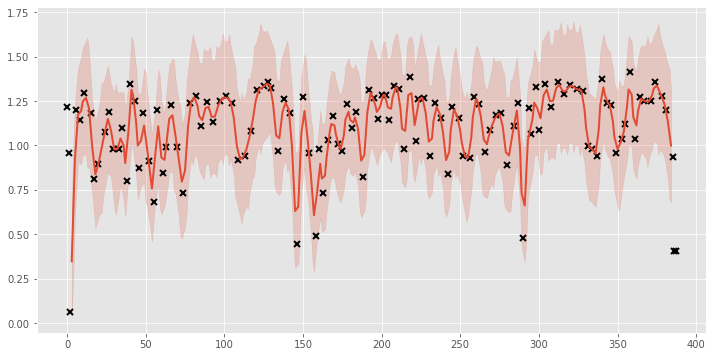

In [7]:

## plot
plt.figure(figsize=(12, 6))
plt.plot(id_train, Y_train, "kx", mew=2)
plt.plot(id_test, mean, "C0", lw=2)
plt.fill_between(
    id_test[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

# plt.plot(id_test, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
# _ = plt.xlim(-0.1, 1.1)

In [8]:
var.shape

TensorShape([267, 1])

In [9]:
a[~np.in1d(a, b)]

NameError: name 'a' is not defined

In [ ]:
# extract the data for the first run
N = 388
n_train= 5
Y_all = np.loadtxt(data_E)
id_all = np.linspace(0,N-1, N)

# I chose n_train gbs as training data set randomly
id_train = np.sort(np.random.choice(N, size=n_train, replace=False))

id_train = np.array(id_train, dtype=np.float64)
id_test = id_all[~np.in1d(id_all,id_train)].reshape(-1,1)

In [ ]:
id_train

In [ ]:
id_test.shape